In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate
from transliterate import translit, get_available_language_codes
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

/Users/rvtsukanov/utils/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('../DATA/01_MAG/first.csv', index_col=None).drop(columns=['Unnamed: 0'])
target = pd.read_csv('../DATA/01_MAG/first_targets.csv', index_col=None, names=['magnetic_loss']).reset_index().drop(columns=['index'])['magnetic_loss']
data = data.drop(target[target.isna()].index)
target = target.dropna()

In [3]:
transliteration_mapping = {col: translit(col, 'ru', reversed=True) for col in data.columns}
transliteration_mapping_inverse = {val: key for key, val in transliteration_mapping.items()}
data.columns = transliteration_mapping_inverse.keys()

In [4]:
import seaborn as sns 

In [5]:
#Prepare targets
#CLASSIFICATION
y_clf = pd.cut(target, [-np.inf, 1.05, 1.26, np.inf], labels=[0, 1, 2])

#REGRESSION
y_reg = target


#BIMODAL CLF
y_bimod = pd.cut(target, [-np.inf, 1.19, np.inf], labels=[0, 1])

### Stage: classifier (3)

In [7]:
estimator_clf = lgb.LGBMClassifier()

##### Recover knowledge about multilabel classification!!!!

In [53]:
from sklearn.model_selection import RandomizedSearchCV

In [56]:
gcv = GridSearchCV(estimator=estimator, param_grid={'num_leaves': [i for i in range(5, 41, 5)],
                                                    'reg_alpha': [i * 0.1 for i in range(0, 11)],
                                                    'reg_lambda': [i * 0.1 for i in range(0, 11)]},
                   verbose=10, cv=StratifiedKFold(n_splits=4, shuffle=True), scoring='f1_macro')

In [10]:
cross_validate(estimator=estimator_clf, 
               X=data,
               y=y_clf,
               cv=StratifiedKFold(n_splits=10, shuffle=True),
               scoring=['accuracy', 'f1_macro'])

In [13]:
estimator_clf.fit(X=data, y=y_clf)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
sorted(zip(estimator_clf.feature_importances_, data.columns), reverse=True)[:20]

[(512, 'Tolschina'),
 (280, 'Temperatura_polosy_na_levoj_motalke_prohod_3'),
 (224, 'Temperatura_polosy_na_pravoj_motalke_prohod_2'),
 (207, 'Temperatura_v_SF1_zona_5'),
 (195, 'Pozitsija_VTO'),
 (194, 'Soderzhanie_H2_v_SF3_MP2'),
 (191, 'Partija_ANO_PDS'),
 (177, 'Trend_temperatury_kontsa_prokatki_M12-02'),
 (173, 'Temperatura_v_SF1_zona_3'),
 (169, 'R17sr'),
 (165, 'Temperatura_v_HEF_zona_2'),
 (158, 'Temperatura_v_SF3_zona_3'),
 (155, 'Temperatura_v_SF1_zona_2'),
 (155, 'Temperatura_v_SF1_zona_1'),
 (154, 'Temperatura_polosy_na_levoj_motalke_prohod_5'),
 (153, 'Temperatura_v_RTF_zona_4'),
 (151, 'Temperatura_v_HEF_zona_1'),
 (139, 'Temperatura_v_SF1_zona_4'),
 (138, 'Temperatura_v_RTF_zona_5'),
 (137, 'Temperatura_polosy_na_pravoj_motalke_prohod_4')]

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()

In [32]:
data_transformed = scaler.fit_transform(data)

In [33]:
from sklearn.linear_model import LogisticRegression

In [35]:
cross_validate(estimator=logreg, 
               X=data_transformed,
               y=y_clf,
               cv=StratifiedKFold(n_splits=10, shuffle=True),
               scoring=['accuracy', 'f1_macro'])

/Users/rvtsukanov/utils/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rvtsukanov/utils/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/rvtsukanov/utils/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rvtsukanov/utils/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/rvtsukanov/utils/anacon

{'fit_time': array([28.30384302, 24.71674228, 32.00610805, 30.88318825, 25.58192468,
        25.46244311, 28.80307817, 27.71723986, 26.15052867, 25.54678917]),
 'score_time': array([0.0159719 , 0.00930095, 0.01117182, 0.01525307, 0.00818515,
        0.00858998, 0.00758815, 0.00746512, 0.01223016, 0.00886989]),
 'test_accuracy': array([0.77447949, 0.77860235, 0.77654092, 0.78164948, 0.78061856,
        0.78515464, 0.75979381, 0.77195876, 0.78041237, 0.78020619]),
 'test_f1_macro': array([0.7926702 , 0.79468415, 0.79526988, 0.79761527, 0.79492985,
        0.80187716, 0.77869846, 0.78938443, 0.7998029 , 0.79611153])}

In [58]:
logreg = LogisticRegression(penalty='l1')
logreg.fit(X=data_transformed, y=y_clf)

/Users/rvtsukanov/utils/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rvtsukanov/utils/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
sorted(zip(list(np.abs(logreg.coef_[0])), data.columns), reverse=True)[:20]

[(4.162655320935779, 'Cn'),
 (3.87854015406054, 'norm_len'),
 (3.852041541531156, 'O2k'),
 (3.7052307435017684, 'Partija_ANO_PDS'),
 (3.1015624553630055, 'Znachenie_CO2_v_SF1_MP1'),
 (2.8589794470412406, 'Tochka_rosy_v_SF1_MP3'),
 (2.698027984688116, 'cold5_len'),
 (2.669645120628873, 'decarb_len'),
 (2.608049128923387, 'cold1_len'),
 (2.5690187117023746, 'ZVO'),
 (2.4199044747496448, 'Sera'),
 (2.255042978690305, 'Soderzhanie_H2_v_SF1_MP3'),
 (2.218679773516994, 'Pozitsija_VTO'),
 (2.105686865004725, 'cold4_len'),
 (2.0078404551551774, 'Nk'),
 (1.893117895415656, 'dsr,_mkm'),
 (1.6451979407973498, 'Tochka_rosy_v_RTF'),
 (1.5370071757412445, 'Massa'),
 (1.5251955907045043, 'Tochka_rosy_v_SF1_MP2'),
 (1.465555905310374, 'cold3_len')]

In [77]:
sorted(zip(list(np.abs(logreg.coef_[1])), data.columns), reverse=True)[:20]

[(8.021740937405092, 'decarb_len'),
 (4.800777718058404, 'cold1_len'),
 (4.552658170496892, 'cold2_len'),
 (3.6408969990734743, 'cold3_len'),
 (3.259415794215515, 'cold4_len'),
 (3.145349420130062, 'O2n'),
 (2.680823911130652, 'norm_len'),
 (2.5831438143438263, 'cold5_len'),
 (1.7353907287259425, 'R17sr'),
 (1.7234896787390641, 'Cn'),
 (1.2528329076737734, 'Tochka_rosy_v_RTF'),
 (1.1502664743908737, 'Soderzhanie_H2_v_SF1_MP3'),
 (1.1496456669559838, 'Znachenie_CO2_v_SF1_MP2'),
 (1.1386147617247693, 'Dlina,_m'),
 (1.0902998922776967, 'Temperatura_polosy_v_zone_4C2_AN'),
 (1.0074881225470347, 'Ssrednee'),
 (0.9484409506923687, 'Svojstva_VPS'),
 (0.9295120205654286, 'Tochka_rosy_v_SF1_MP2'),
 (0.8719654693164841, 'Temperatura_polosy_v_zone_4B__AN'),
 (0.8261426416366187, 'magn_len')]

In [78]:
sorted(zip(list(np.abs(logreg.coef_[2])), data.columns), reverse=True)[:20]

[(9.681762693672807, 'Partija_ANO_PDS'),
 (6.346936276845632, 'Massa'),
 (6.261834838075481, 'Soderzhnanie_H2_v_RTF'),
 (4.785754910789641, 'Tolsch_'),
 (3.8205798272407616, 'magn_len'),
 (3.7736007259136195, 'Sk'),
 (3.468037107560718, 'Nn'),
 (3.405117762688852, 'Svojstva_VPS'),
 (2.94008359432822, 'cold4_len'),
 (2.860575351433163, 'Pozitsija_VTO'),
 (2.776512024198693, 'cold2_len'),
 (2.776144851622438, 'Soderzhanie_H2_v_SF1_MP2'),
 (2.686967226371109, 'Nsrednee'),
 (2.4523353006404336, 'cold1_len'),
 (2.3828314547539615, 'Cn'),
 (2.2628396881535005, 'cold3_len'),
 (2.2007685596109274, 'Nk'),
 (2.0899258023144793, 'Kremnij'),
 (2.0552786778278893, 'Shirina'),
 (1.9932682949243903, 'O2k')]

In [85]:
total_imp = []
for i in range(3):
    new_imp = {}
    for key, name in sorted(zip(list(np.abs(logreg.coef_[i])), data.columns), reverse=True)[:20]:
        new_imp[transliteration_mapping_inverse[name]] = key
    total_imp.append(new_imp)

In [86]:
total_imp

[{'Cн': 4.162655320935779,
  'norm_len': 3.87854015406054,
  'О2к': 3.852041541531156,
  'Партия_АНО_ПДС': 3.7052307435017684,
  'Значение_CO2_в_SF1_MP1': 3.1015624553630055,
  'Точка_росы_в_SF1_MP3': 2.8589794470412406,
  'cold5_len': 2.698027984688116,
  'decarb_len': 2.669645120628873,
  'cold1_len': 2.608049128923387,
  'ЗВО': 2.5690187117023746,
  'Сера': 2.4199044747496448,
  'Содержание_H2_в_SF1_MP3': 2.255042978690305,
  'Позиция_ВТО': 2.218679773516994,
  'cold4_len': 2.105686865004725,
  'Nк': 2.0078404551551774,
  'dср,_мкм': 1.893117895415656,
  'Точка_росы_в_RTF': 1.6451979407973498,
  'Масса': 1.5370071757412445,
  'Точка_росы_в_SF1_MP2': 1.5251955907045043,
  'cold3_len': 1.465555905310374},
 {'decarb_len': 8.021740937405092,
  'cold1_len': 4.800777718058404,
  'cold2_len': 4.552658170496892,
  'cold3_len': 3.6408969990734743,
  'cold4_len': 3.259415794215515,
  'O2н': 3.145349420130062,
  'norm_len': 2.680823911130652,
  'cold5_len': 2.5831438143438263,
  'Р17ср': 1.735

### Stage: classifier (bimodal target)

In [97]:
cross_validate(estimator=estimator_bimod,
               X=data.drop(columns=['R17sr']),
               y=y_bimod,
               cv=StratifiedKFold(n_splits=10, shuffle=True),
               scoring=['accuracy', 'f1_macro', 'f1_micro'])

{'fit_time': array([3.5298214 , 3.35432005, 3.64341497, 3.52053595, 2.86661577,
        3.59178805, 3.45894408, 3.19733286, 3.41358423, 2.911587  ]),
 'score_time': array([0.13653684, 0.13552499, 0.29410911, 0.13559318, 0.24641824,
        0.14205194, 0.13530111, 0.14099097, 0.13643074, 0.13579297]),
 'test_accuracy': array([0.99587799, 0.99732014, 0.99649485, 0.99463918, 0.99587629,
        0.99608247, 0.9956701 , 0.99608247, 0.99546392, 0.99628866]),
 'test_f1_macro': array([0.99488479, 0.99667259, 0.99564252, 0.99334315, 0.99487935,
        0.99512766, 0.99461478, 0.99514305, 0.99435706, 0.99539557]),
 'test_f1_micro': array([0.99587799, 0.99732014, 0.99649485, 0.99463918, 0.99587629,
        0.99608247, 0.9956701 , 0.99608247, 0.99546392, 0.99628866])}

In [88]:
estimator_bimod = lgb.LGBMClassifier()

In [95]:
estimator_bimod.fit(X=data.drop(columns=['R17sr']), y=y_bimod)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [96]:
sorted(zip(estimator_bimod.feature_importances_, data.columns), reverse=True)[:20]

[(181, 'decarb_len'),
 (127, 'Trend_temperatury_kontsa_prokatki_M12-02'),
 (81, 'Shirina'),
 (74, 'Znachenie_CO2_v_SF1_MP2'),
 (73, 'Pozitsija_VTO'),
 (72, 'Znachenie_CO2_v_SF1_MP4'),
 (70, 'Temperatura_v_SF1_zona_1'),
 (69, 'Temperatura_polosy_v_zone_4C2_AN'),
 (67, 'Temperatura_v_SF3_zona_2'),
 (67, 'Massa'),
 (62, 'Soderzhanie_H2_v_SF3_MP2'),
 (61, 'Temperatura_v_SF1_zona_7'),
 (61, 'Dlina,_m'),
 (55, 'R17sr'),
 (53, 'cold4_len'),
 (52, 'Soderzhanie_NH3_v_SF3_MP2'),
 (50, 'Trend_temperatury_za_5-j_kl__M12-02'),
 (49, 'Tochka_rosy_v_RTF'),
 (47, 'cold1_len'),
 (47, 'Temperatura_v_SF3_zona_1')]

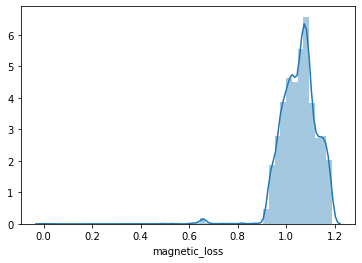

In [98]:
sns.distplot(y_reg[y_reg <= 1.19])